## Các thư viện cần thiết

In [7]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [8]:
df = pd.read_csv(r"D:\NAM 3\Ki II\Đồ án II\dataset\du_lieu_da_xu_ly (1).csv",encoding='utf-8')

In [9]:
df.head()

,title,price,ratings,num_rates,screen_size,refresh_rate,chipset,GPU,sim_slot,operating_system,storage_GB,battery_mAh,RAM_in_GB
0,ASUS ROG Phone 6 12GB 256GB,14490000,5.0,20,6.78,120,Qualcomm ® Snapdragon ® 8+ thế hệ 1,Adreno ™ 730,2 SIM (Nano-SIM),Android,256.0,6000,12.0
1,BENCO V91 4GB 128GB,2690000,5.0,1,6.56,90,Unisoc T606,Adreno 610,2 SIM (Nano-SIM),Android,128.0,5000,8.0
2,Benco S1 Pro 8GB 256GB,4290000,5.0,10,6.80,120,Unisoc T616,Mali-G57,2 SIM (Nano-SIM),Android,256.0,5000,16.0
3,INOI 288S 4G,1000000,5.0,1,2.00,120,Apple A18 Pro,Adreno 610,2 SIM (Nano-SIM),Android,192.0,1000,8.0
4,INOI Note 13s 8GB 256GB,2790000,5.0,2,6.95,120,Unisoc T606,Adreno 610,2 SIM (Nano-SIM),Android,256.0,5000,8.0


In [10]:
# Thêm cột brand bằng cách tách tên hãng từ title
df['brand'] = df['title'].apply(lambda x: x.split()[0])

## Thống kê mô tả về giá.

In [11]:
# 4. Thống kê mô tả cơ bản
price_stats = df['price'].describe()

summary_table = pd.DataFrame({
    'Chỉ số thống kê': ['Số lượng quan sát (count)', 'Giá trung bình (mean)', 'Độ lệch chuẩn (std)', 
                        'Giá thấp nhất (min)', 'Phân vị thứ 25 (Q1)', 'Trung vị (median)', 
                        'Phân vị thứ 75 (Q3)', 'Giá cao nhất (max)'],
    'Giá trị (VNĐ)': [
        int(price_stats['count']),
        int(price_stats['mean']),
        int(price_stats['std']),
        int(price_stats['min']),
        int(price_stats['25%']),
        int(price_stats['50%']),
        int(price_stats['75%']),
        int(price_stats['max']),
    ]
})

print("\nTHỐNG KÊ MÔ TẢ CƠ BẢN VỀ GIÁ")
print(summary_table.to_string(index=False))



THỐNG KÊ MÔ TẢ CƠ BẢN VỀ GIÁ
          Chỉ số thống kê  Giá trị (VNĐ)
Số lượng quan sát (count)            283
    Giá trung bình (mean)       11764134
      Độ lệch chuẩn (std)       10854246
      Giá thấp nhất (min)         450000
      Phân vị thứ 25 (Q1)        3625000
        Trung vị (median)        6490000
      Phân vị thứ 75 (Q3)       19490000
       Giá cao nhất (max)       45990000


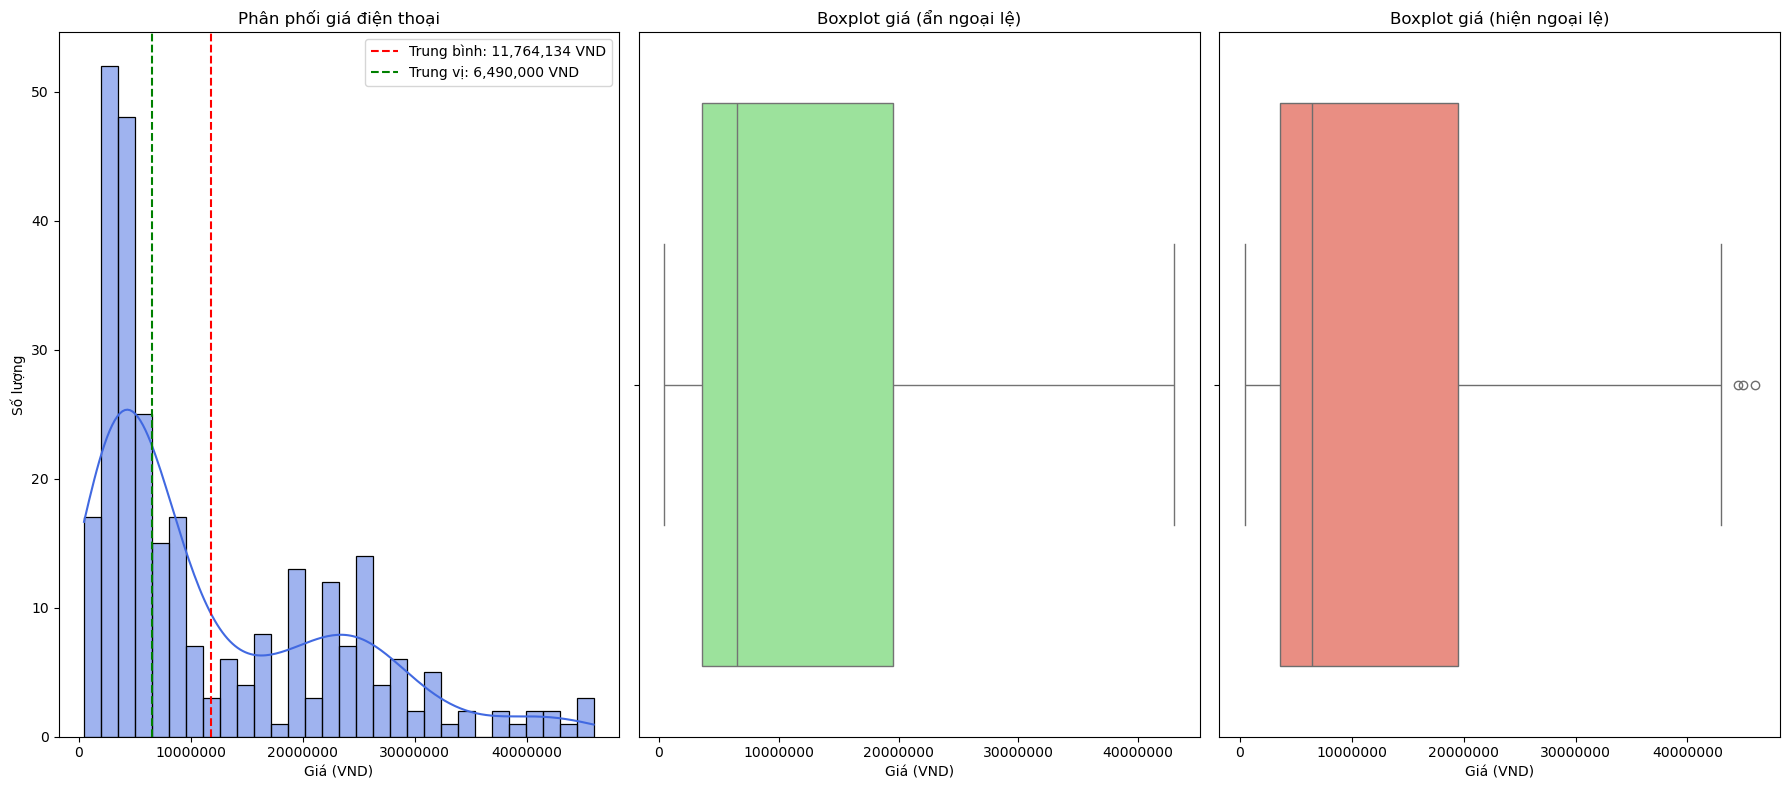

In [12]:
plt.figure(figsize=(18, 8))

# 1. Biểu đồ phân phối giá
plt.subplot(1, 3, 1)
sns.histplot(df['price'], bins=30, kde=True, color='royalblue')
plt.axvline(df['price'].mean(), color='red', linestyle='--', label=f'Trung bình: {df["price"].mean():,.0f} VND')
plt.axvline(df['price'].median(), color='green', linestyle='--', label=f'Trung vị: {df["price"].median():,.0f} VND')
plt.title('Phân phối giá điện thoại')
plt.xlabel('Giá (VND)')
plt.ylabel('Số lượng')
plt.legend()
plt.ticklabel_format(style='plain', axis='x')

# 2. Boxplot không có ngoại lệ (để xem cấu trúc chính)
plt.subplot(1, 3, 2)
sns.boxplot(x=df['price'], showfliers=False, color='lightgreen')
plt.title('Boxplot giá (ẩn ngoại lệ)')
plt.xlabel('Giá (VND)')
plt.ticklabel_format(style='plain', axis='x')

# 3. Boxplot có ngoại lệ (để thấy rõ outliers)
plt.subplot(1, 3, 3)
sns.boxplot(x=df['price'], color='salmon')  # showfliers mặc định = True
plt.title('Boxplot giá (hiện ngoại lệ)')
plt.xlabel('Giá (VND)')
plt.ticklabel_format(style='plain', axis='x')

plt.tight_layout()
plt.show()



PHÂN BỐ THEO PHÂN KHÚC GIÁ
price_segment
Dưới 5tr     117
5-15tr        77
15-30tr       70
Trên 30tr     19
Name: count, dtype: int64


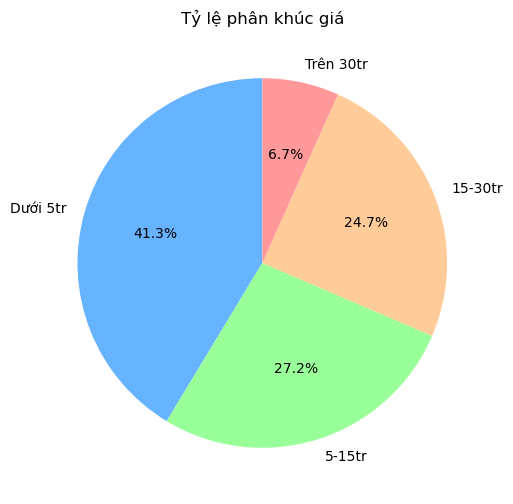

In [13]:
# Phân loại theo phân khúc giá
df['price_segment'] = pd.cut(df['price'], 
                            bins=[0, 5e6, 15e6, 30e6, float('inf')],
                            labels=['Dưới 5tr', '5-15tr', '15-30tr', 'Trên 30tr'])

# Thống kê số lượng theo phân khúc
segment_stats = df['price_segment'].value_counts().sort_index()
print("\nPHÂN BỐ THEO PHÂN KHÚC GIÁ")
print(segment_stats)

# Vẽ biểu đồ phân khúc
plt.figure(figsize=(8, 6))
segment_stats.plot(kind='pie', autopct='%1.1f%%', startangle=90, 
                  colors=['#66b3ff','#99ff99','#ffcc99','#ff9999'])
plt.title('Tỷ lệ phân khúc giá')
plt.ylabel('')
plt.show()

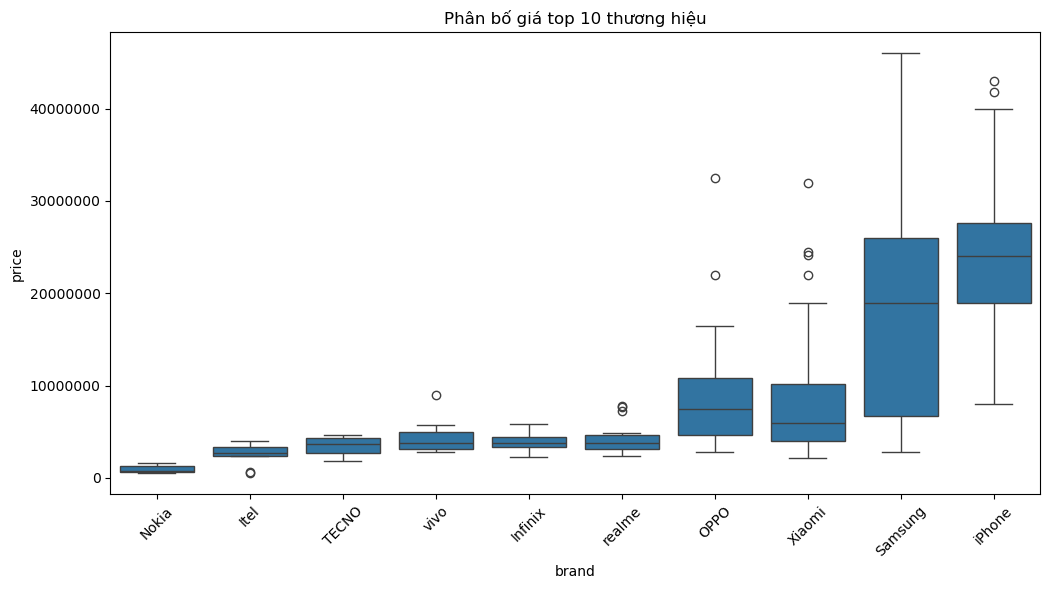

In [14]:
top_brands = df['brand'].value_counts().head(10).index
df_top = df[df['brand'].isin(top_brands)]

plt.figure(figsize=(12, 6))
sns.boxplot(x='brand', y='price', data=df_top)
plt.title('Phân bố giá top 10 thương hiệu')
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

## Thống kê mô tả về RAM.

In [15]:
print(df['RAM_in_GB'].describe())

count    283.000000
mean       8.064212
std        3.367604
min        0.046875
25%        6.000000
50%        8.000000
75%        8.000000
max       28.000000
Name: RAM_in_GB, dtype: float64


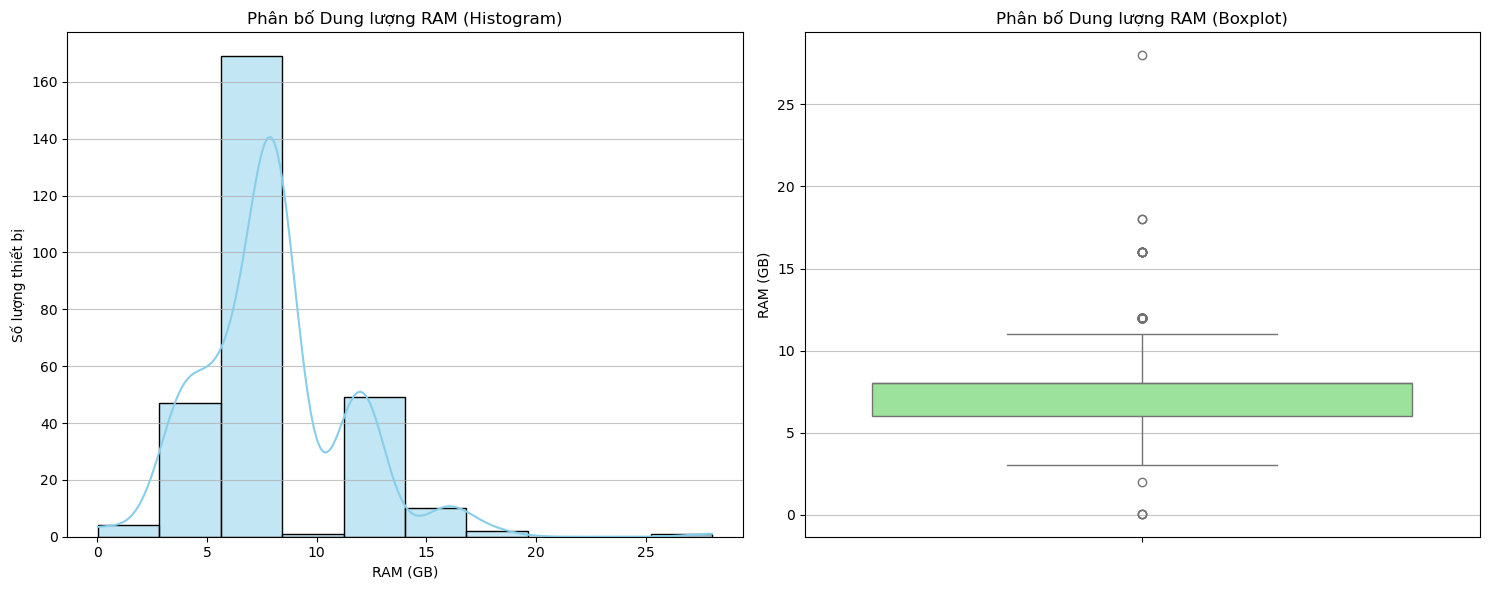

In [16]:
plt.figure(figsize=(15, 6))

# Biểu đồ tần suất (Histogram)
plt.subplot(1, 2, 1) # 1 hàng, 2 cột, biểu đồ thứ nhất
sns.histplot(df['RAM_in_GB'], bins=10, kde=True, color='skyblue')
plt.title('Phân bố Dung lượng RAM (Histogram)')
plt.xlabel('RAM (GB)')
plt.ylabel('Số lượng thiết bị')
plt.grid(axis='y', alpha=0.75)

# Biểu đồ hộp (Boxplot)
plt.subplot(1, 2, 2) # 1 hàng, 2 cột, biểu đồ thứ hai
sns.boxplot(y=df['RAM_in_GB'], color='lightgreen')
plt.title('Phân bố Dung lượng RAM (Boxplot)')
plt.ylabel('RAM (GB)')
plt.grid(axis='y', alpha=0.75)

plt.tight_layout() # Tự động điều chỉnh khoảng cách giữa các biểu đồ
plt.show()

In [17]:
# Đếm tần suất xuất hiện của từng giá trị RAM
ram_counts = df['RAM_in_GB'].value_counts().sort_index()
print("\nCác giá trị RAM và số lượng xuất hiện:")
print(ram_counts)

# In ra các giá trị RAM phổ biến nhất (top 5 chẳng hạn)
print("\nTop 5 giá trị RAM phổ biến nhất:")
print(df['RAM_in_GB'].value_counts().head(5))


Các giá trị RAM và số lượng xuất hiện:
RAM_in_GB
0.046875       1
0.062500       2
2.000000       1
3.000000       4
4.000000      42
5.000000       1
6.000000      40
8.000000     129
11.000000      1
12.000000     49
16.000000     10
18.000000      2
28.000000      1
Name: count, dtype: int64

Top 5 giá trị RAM phổ biến nhất:
RAM_in_GB
8.0     129
12.0     49
4.0      42
6.0      40
16.0     10
Name: count, dtype: int64


## Thống kê mô tả khác.

--- Thống kê mô tả cho các cột số ---
          ratings   num_rates  screen_size  refresh_rate   storage_GB  \
count  283.000000  283.000000   283.000000    283.000000   283.000000   
mean     4.905654   21.257951     6.387032    105.943463   228.583481   
std      0.142557   36.163545     1.040207     21.347438   183.736618   
min      4.000000    1.000000     1.770000     60.000000     0.125000   
25%      4.850000    5.000000     6.500000     90.000000   128.000000   
50%      5.000000   10.000000     6.670000    120.000000   192.000000   
75%      5.000000   21.000000     6.715000    120.000000   256.000000   
max      5.000000  287.000000     7.820000    144.000000  1024.000000   

       battery_mAh  
count   283.000000  
mean   4648.618375  
std     965.610215  
min     800.000000  
25%    4655.000000  
50%    5000.000000  
75%    5000.000000  
max    7000.000000  




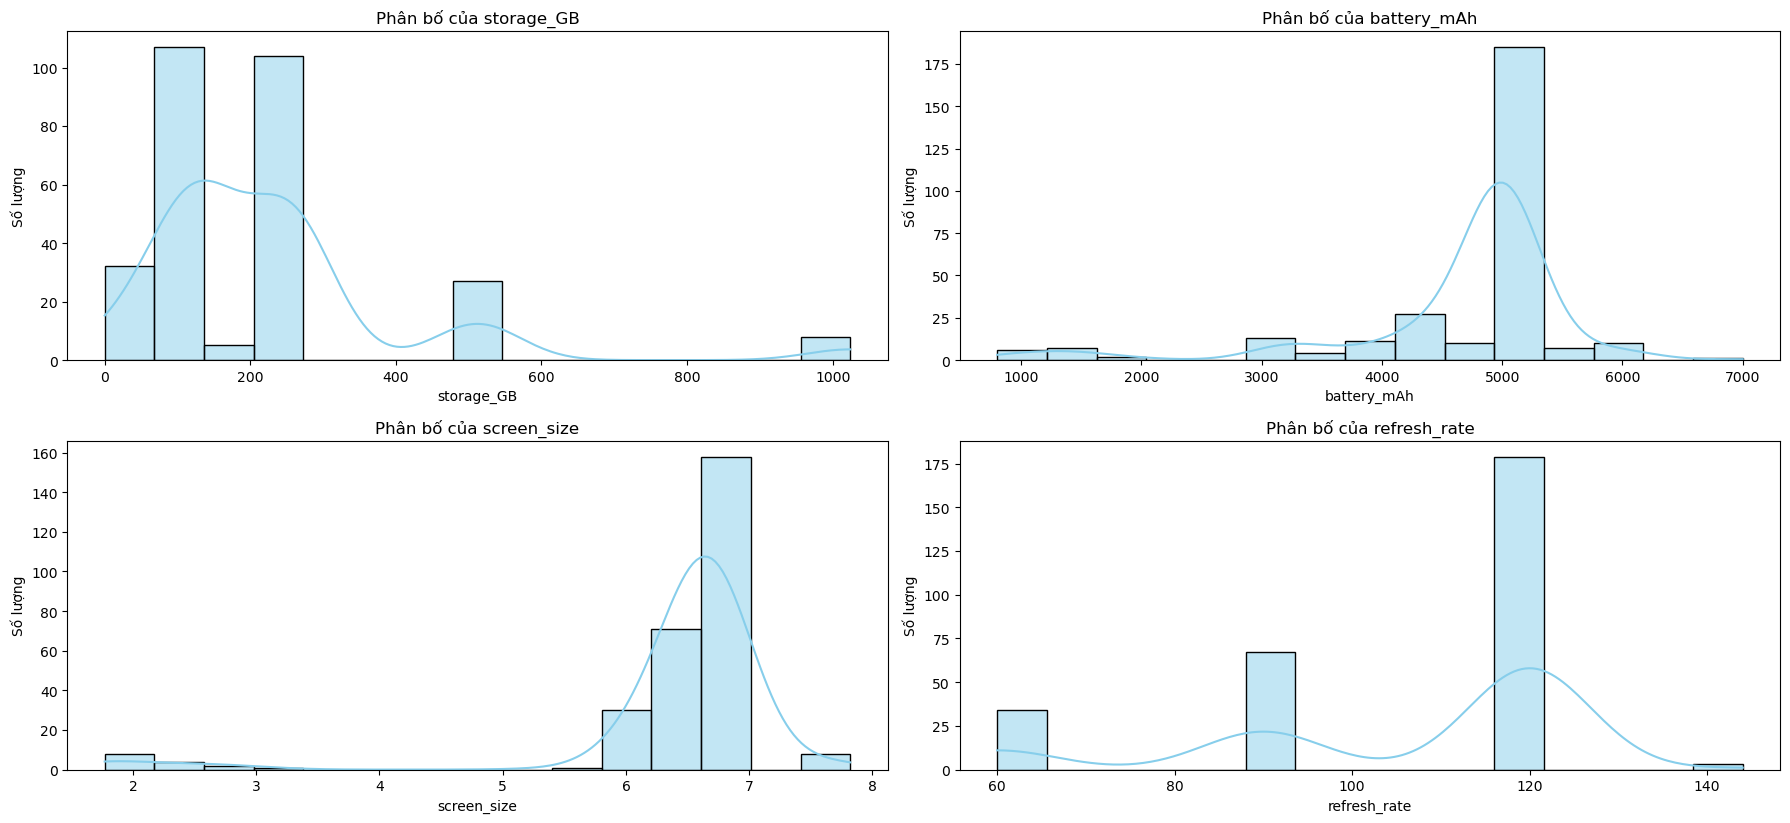

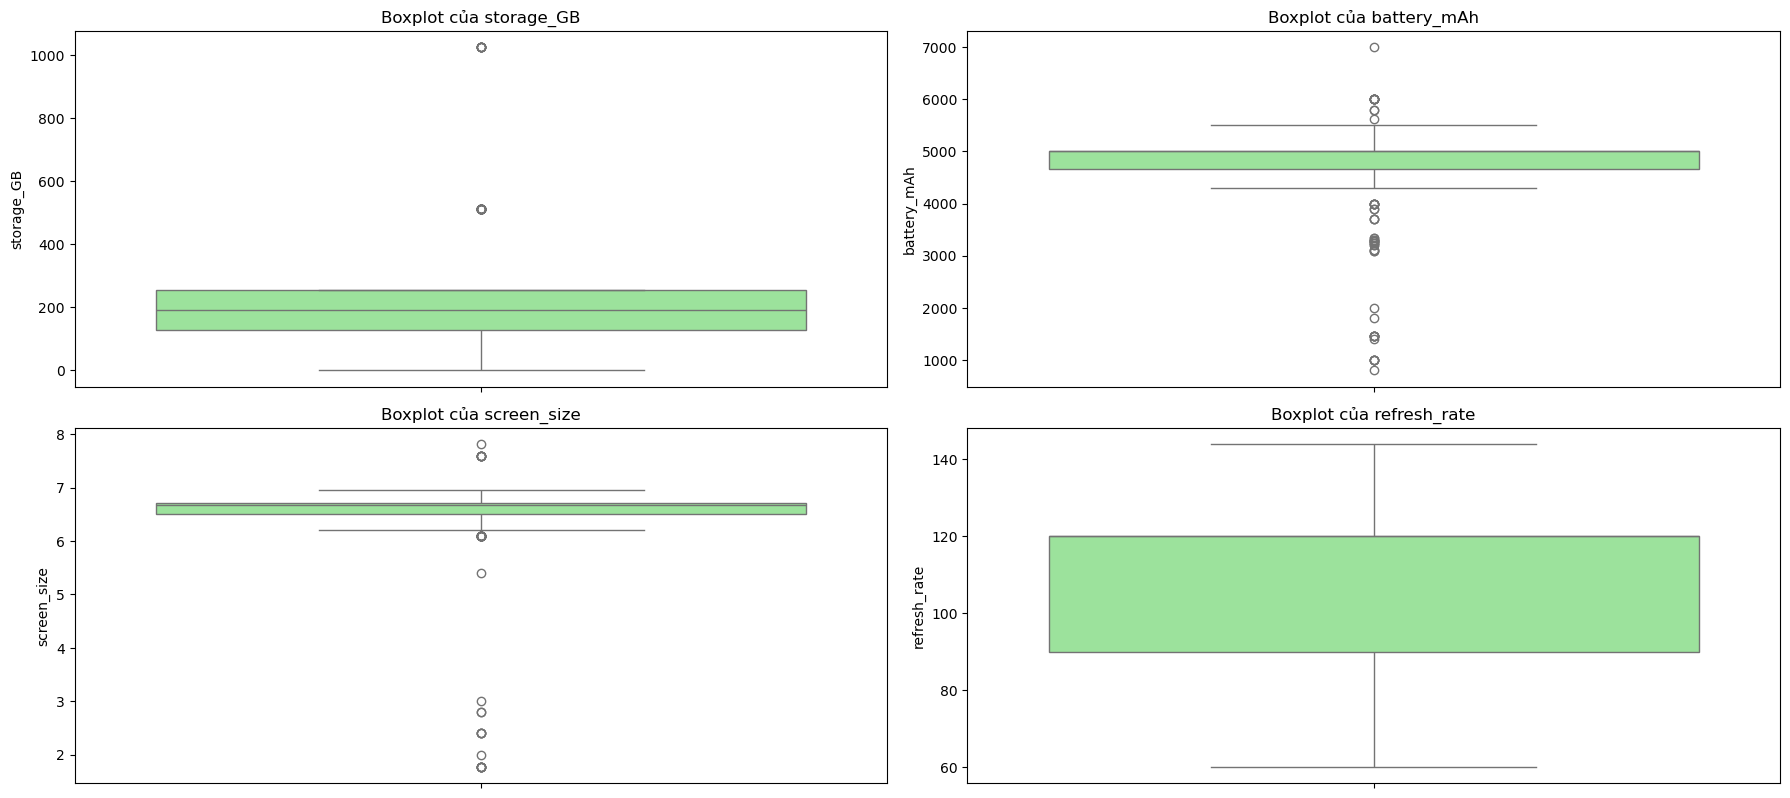

In [18]:
print("--- Thống kê mô tả cho các cột số ---")
print(df[['ratings', 'num_rates', 'screen_size', 'refresh_rate', 'storage_GB', 'battery_mAh']].describe())
print("\n")

# --- 3. Trực quan hóa Phân bố Dữ liệu Số ---
numeric_features = ['storage_GB', 'battery_mAh', 'screen_size', 'refresh_rate']

plt.figure(figsize=(18, 12))
for i, feature in enumerate(numeric_features):
    plt.subplot(3, 2, i + 1) # 3 hàng, 2 cột
    sns.histplot(df[feature], bins=15, kde=True, color='skyblue')
    plt.title(f'Phân bố của {feature}')
    plt.xlabel(feature)
    plt.ylabel('Số lượng')
plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 12))
for i, feature in enumerate(numeric_features):
    plt.subplot(3, 2, i + 1)
    sns.boxplot(y=df[feature], color='lightgreen')
    plt.title(f'Boxplot của {feature}')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()


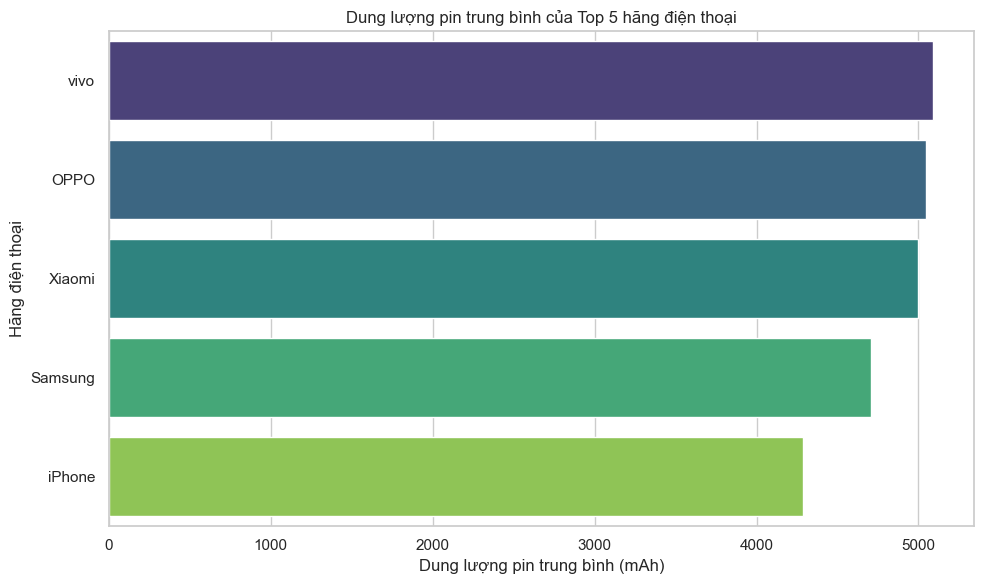

brand
vivo       5088.235294
OPPO       5049.400000
Xiaomi     4999.428571
Samsung    4707.812500
iPhone     4286.000000
Name: battery_mAh, dtype: float64

In [22]:
# Thêm cột 'brand' bằng cách lấy từ đầu tiên trong 'title'
df['brand'] = df['title'].apply(lambda x: x.split()[0])

# Lọc ra top 5 hãng có nhiều sản phẩm nhất
top_5_brands = df['brand'].value_counts().head(5).index

# Lọc dữ liệu theo top 5 hãng
df_top5 = df[df['brand'].isin(top_5_brands)]

# Tính trung bình dung lượng pin theo hãng
avg_battery_by_brand = df_top5.groupby("brand")["battery_mAh"].mean().sort_values(ascending=False)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_battery_by_brand.values, y=avg_battery_by_brand.index, palette="viridis")
plt.xlabel("Dung lượng pin trung bình (mAh)")
plt.ylabel("Hãng điện thoại")
plt.title("Dung lượng pin trung bình của Top 5 hãng điện thoại")
plt.tight_layout()
plt.show()

# Hiển thị kết quả trung bình
avg_battery_by_brand


--- Phân tích tần suất cho các cột phân loại ---

--- Tần suất của chipset ---
chipset
Apple A18 Pro                               13
Unisoc T606                                  7
MediaTek Helio G85 8 nhân                    7
Snapdragon 8 Elite dành cho Galaxy (3nm)     7
Apple A14 Bionic (5 nm)                      6
                                            ..
Exynos 2400e (4nm)                           1
Snapdragon 8 plus Gen 1 8 nhân               1
Snapdragon 8 Gen 3 For Galaxy                1
MediaTek Dimensity 9300+                     1
MediaTek Helio G99-Ultra                     1
Name: count, Length: 151, dtype: int64


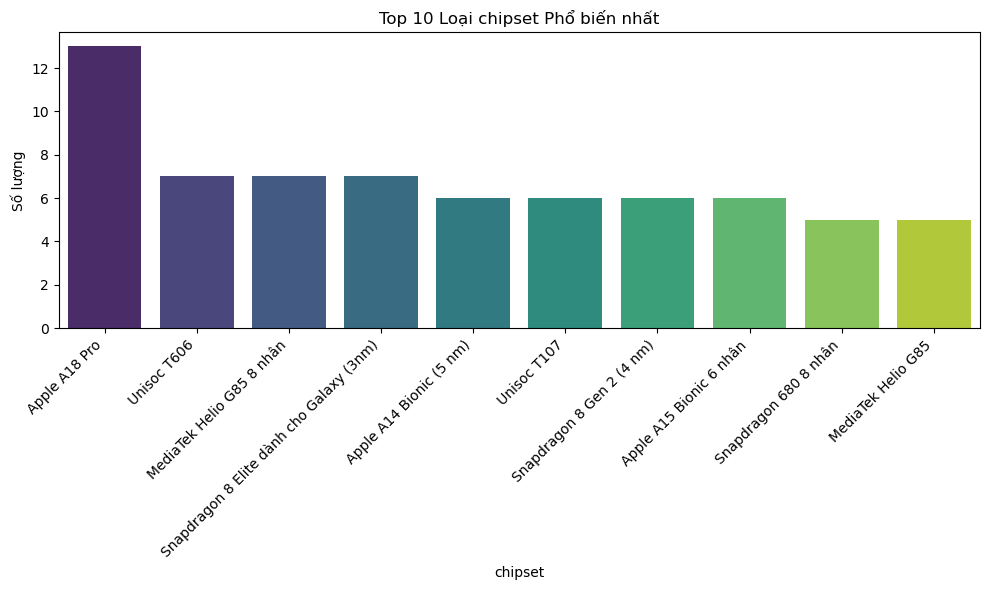


--- Tần suất của sim_slot ---
sim_slot
2 SIM (Nano-SIM)                                156
2 SIM (nano‑SIM và eSIM)                         43
2 Nano-SIM                                       23
Sim kép (nano-Sim và e-Sim) - Hỗ trợ 2 e-Sim     19
SIM 1 + SIM 2 / SIM 1 + eSIM / 2 eSIM            12
2 Nano SIM hoặc 1 Nano + 1 eSIM                   9
2 Nano-SIM + eSIM                                 8
Nano-SIM                                          3
Nano-SIM + eSIM                                   3
Dual nano-SIM hoặc 1 nano-SIM + 1 eSIM            2
Micro-SIM + Nano SIM                              2
1 Nano SIM + 1 eSIM hoặc 2 eSIM                   2
Micro-SIM                                         1
Name: count, dtype: int64


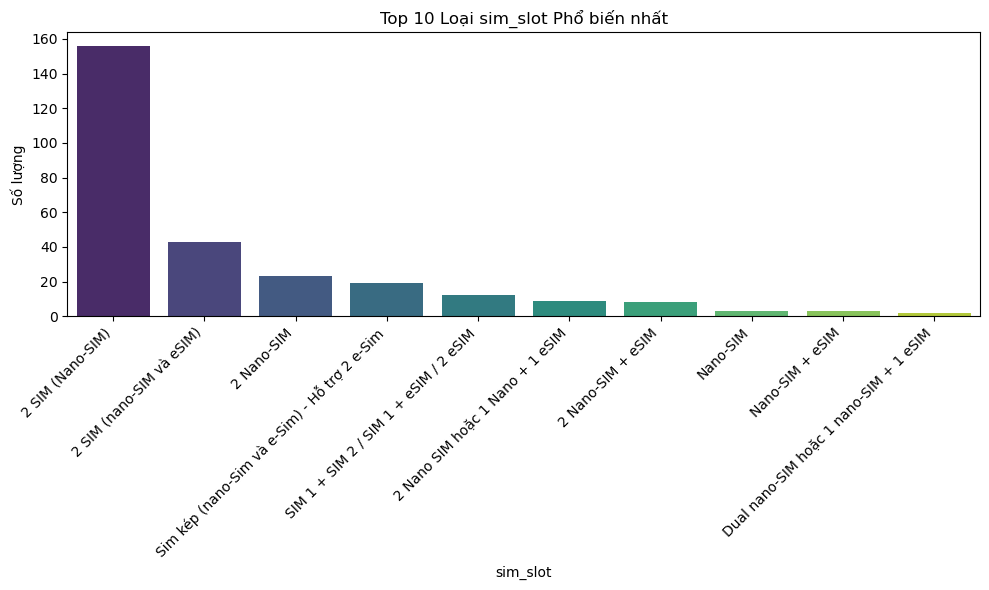


--- Tần suất của operating_system ---
operating_system
Android    225
iOS         49
Khác         6
S30+         3
Name: count, dtype: int64


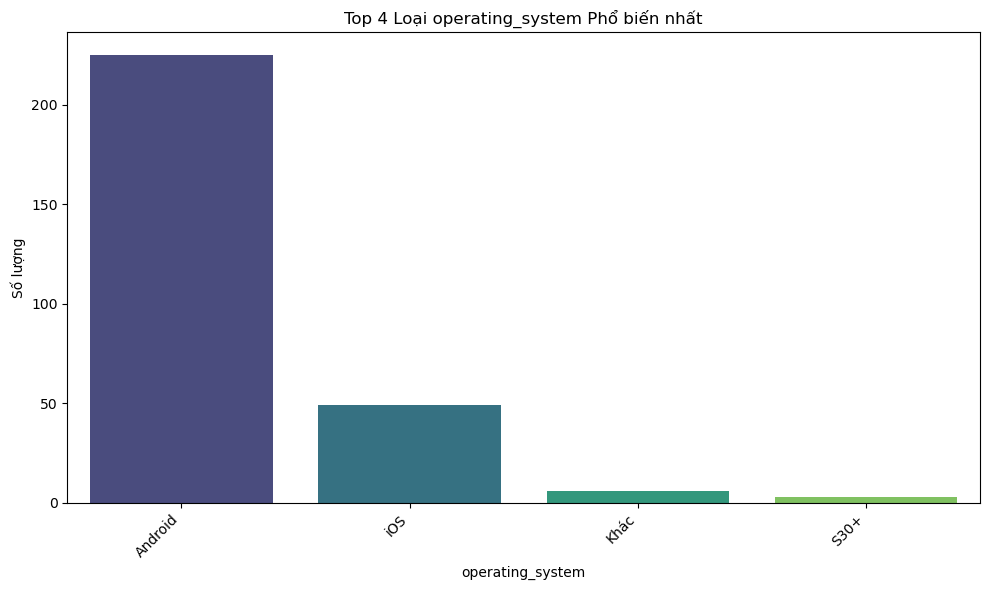


--- Phân tích mối quan hệ ---


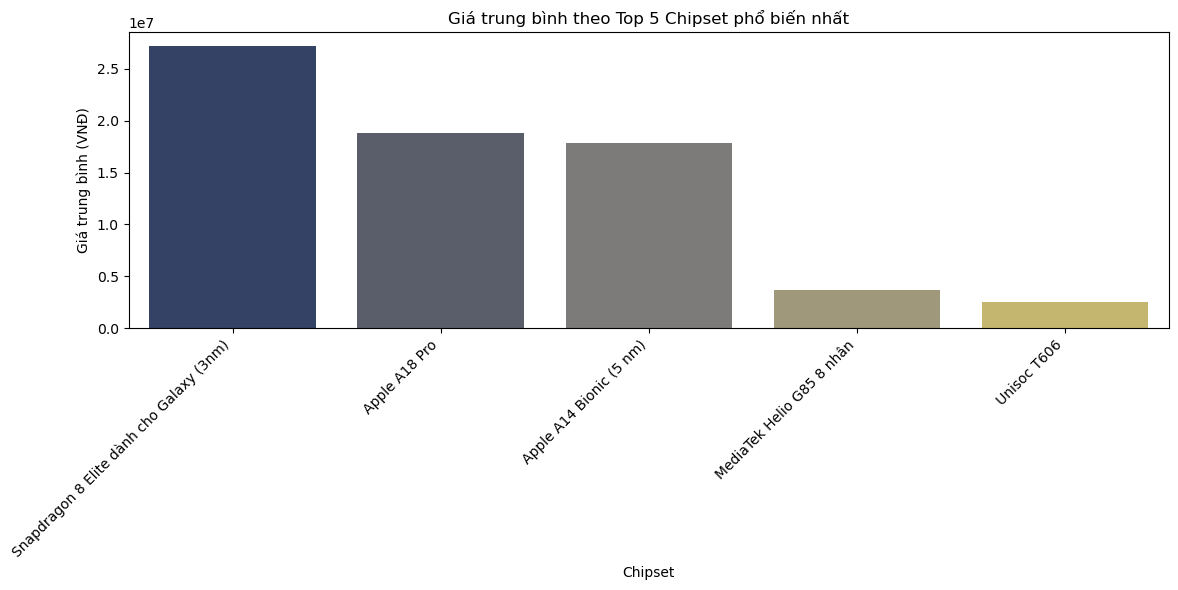

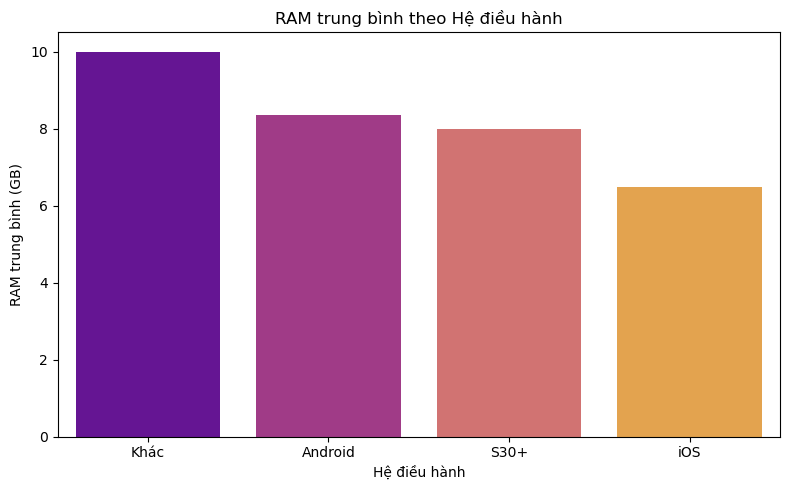

In [19]:
# --- 4. Phân tích Tần suất cho các Cột Phân loại ---
# Điều chỉnh tên cột GPU nếu cần, trong ảnh là một phần của chipset và sim_slot
# Trong dữ liệu mẫu của tôi, 'GPU' được tạo riêng, nếu của bạn nó là phần của cột khác thì bạn phải xử lý để tách nó ra
categorical_features = ['chipset', 'sim_slot', 'operating_system'] # Loại bỏ 'GPU' vì nó nằm trong 'chipset' hoặc 'sim_slot' trong hình ảnh

print("\n--- Phân tích tần suất cho các cột phân loại ---")
for feature in categorical_features:
    print(f"\n--- Tần suất của {feature} ---")
    print(df[feature].value_counts())
    
    # Trực quan hóa tần suất (Top 10 nếu có quá nhiều danh mục)
    plt.figure(figsize=(10, 6))
    top_categories = df[feature].value_counts().head(10)
    sns.barplot(x=top_categories.index, y=top_categories.values, palette='viridis')
    plt.title(f'Top {len(top_categories)} Loại {feature} Phổ biến nhất')
    plt.xlabel(feature)
    plt.ylabel('Số lượng')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# --- 5. Phân tích mối quan hệ đơn giản (một vài ví dụ) ---

print("\n--- Phân tích mối quan hệ ---")



# So sánh giá trung bình theo loại Chipset (Top 5 Chipset)
plt.figure(figsize=(12, 6))
# Lấy top 5 chipset phổ biến nhất trước khi tính trung bình để tránh quá nhiều danh mục
top_5_chipsets = df['chipset'].value_counts().head(5).index
df_filtered_chipset = df[df['chipset'].isin(top_5_chipsets)]
avg_price_by_chipset = df_filtered_chipset.groupby('chipset')['price'].mean().sort_values(ascending=False)
sns.barplot(x=avg_price_by_chipset.index, y=avg_price_by_chipset.values, palette='cividis')
plt.title('Giá trung bình theo Top 5 Chipset phổ biến nhất')
plt.xlabel('Chipset')
plt.ylabel('Giá trung bình (VNĐ)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# So sánh RAM trung bình theo Hệ điều hành
plt.figure(figsize=(8, 5))
avg_ram_by_os = df.groupby('operating_system')['RAM_in_GB'].mean().sort_values(ascending=False)
sns.barplot(x=avg_ram_by_os.index, y=avg_ram_by_os.values, palette='plasma')
plt.title('RAM trung bình theo Hệ điều hành')
plt.xlabel('Hệ điều hành')
plt.ylabel('RAM trung bình (GB)')
plt.tight_layout()
plt.show()

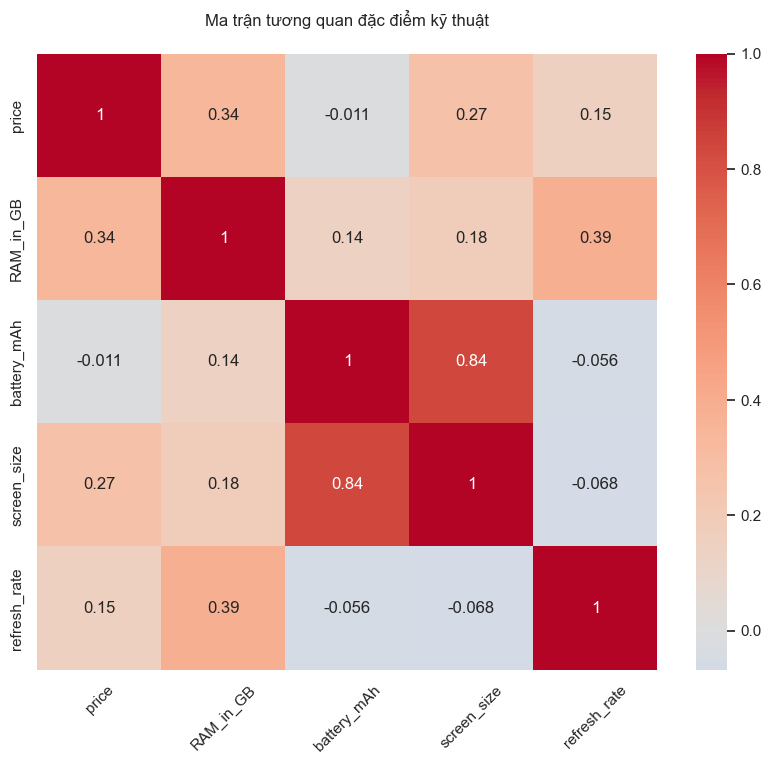

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Thiết lập giao diện đồ họa bằng seaborn
sns.set_theme(style="whitegrid", palette="husl")

# 1. Phân tích tương quan đa biến
numeric_cols = ['price', 'RAM_in_GB', 'battery_mAh', 'screen_size', 'refresh_rate']
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Ma trận tương quan đặc điểm kỹ thuật', pad=20)
plt.xticks(rotation=45)
plt.show()
